# The Urban Built Heritage in the Airbnb Listing Description: A case study in Shanghai

## Introduction

The preservation of urban built heritages is seen as valuable. In some places, the historic environment has moved from being seen as a tool to attract human and financial capital to something that can sustain communities - a tool for economic and social development (Madgin, 2020). At the same time, the heritage branding made by hosts using some things like urban built heritages, it has positive impact on the sharing economy and on tourism. (Fierro and Aranburu, 2019). In Shanghai, the government is also increasingly concerned with preserving heritage buildings in order to use them as selling points (Peh, 2014). However, the conservation of historic buildings requires not only government promotion, but also public participation. A study pointed out that, although more has been done than before to preserve historic buildings as a basis for urban conservation, public understanding of the value of urban heritage conservation has not been able to be valued (Liu et al., 2019).

Therefore, this study will use the Shanghai Airbnb listing descriptions as a sample to mine the urban built heritage mentioned in the listing descriptions by text mining. Then, based on the results of text mining, this study will analyse the characteristics of urban built heritage in Airbnb listing descriptions numerically and spatially through statistical descriptions, correlation coefficient calculations, mapping, and kernel density mapping, to understand residents' responses to the protected urban built heritage.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from tabulate import tabulate

In [2]:
#import the dataset used in below data analysis
#the airbnb list
airbnb = pd.read_csv("result.csv", encoding='utf-8')
# print(airbnb.shape)
#the urban heritage list
p = pd.read_csv("listing_final.csv", encoding='utf-8')
# print(p.shape)
# the airbnb list which mentioned the specified urban heritage
result = airbnb[airbnb['keyword']!='0']
result = result.reset_index(drop=True)
result['keyword'] = [tuple(i.split(",")) for i in result['keyword']]

#transfer to geodataframe
#the urban heritage list
p_g = gpd.GeoDataFrame(p,geometry = gpd.points_from_xy(p.new_x,p.new_y),crs = 'EPSG:4326')
p_g = p_g.to_crs(4490)
#the airbnb
airbnb_g = gpd.GeoDataFrame(airbnb,geometry = gpd.points_from_xy(airbnb.longitude,airbnb.latitude),crs = 'EPSG:4326')
airbnb_g = airbnb_g.to_crs(4490)
#the result
result_g = gpd.GeoDataFrame(result,geometry = gpd.points_from_xy(result.longitude,result.latitude),crs = 'EPSG:4326')
result_g = result_g.to_crs(4490)

## Data and Methods

### Data Collection

The data collection is divided into two parts. The first part is the collection of data related to Shanghai Airbnb listings. In this part, the data was taken from Inside Airbnb (insideairbnb.com). Given that on 24 May 2022 Airbnb announced that it would suspend support for travel listings, experiences and related bookings (Welle, 2022) in China mainland from 30 July 2022, this paper used data from the March 2022 Shanghai Airbnb listings obtained directly from the Inside Airbnb website. The second part of the data collection is to collect the list of Shanghai's protected urban built heritages. At present, Shanghai's protected urban built heritages are divided into national and city levels. The city level protected list contains a large number of buildings that cannot be uniquely identified, e.g. residences, which may affect text identification. Therefore, this study used 55 national-level built heritage in Shanghai (56 in all originally, with the Bund Historic District and the Bund Historic Buildings merged into the latter). Figure 1 shows the flow chart of the built heritages collection. Figures 2-5 show the number of different built heritages in different districts.

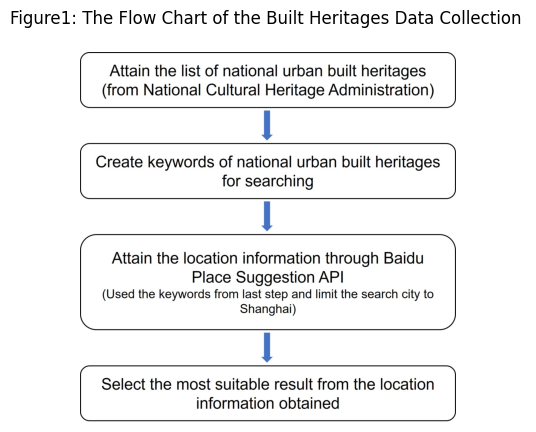

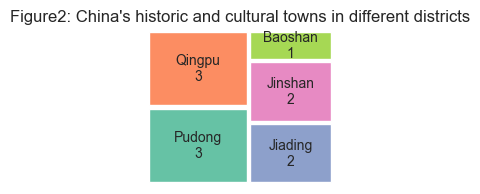

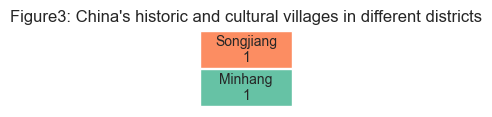

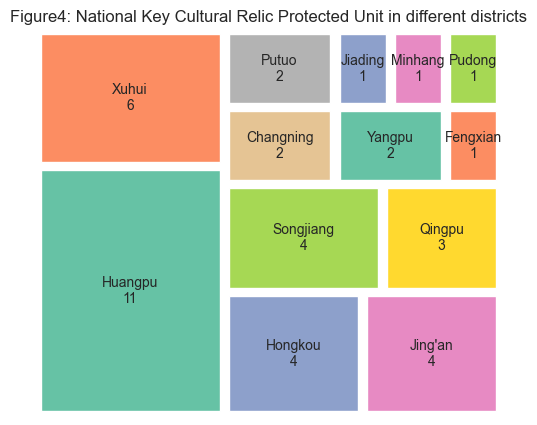

In [3]:
img = plt.imread('pic/Figure 1.jpg')
plt.imshow(img)
plt.title('Figure1: The Flow Chart of the Built Heritages Data Collection \n')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

index12 = []
amount = []
n = 0
for i in p.groupby('type')['district'].value_counts().index:
    index12.append(i)
    amount.append(p.groupby('type')['district'].value_counts()[n])
    n +=1
type_s = []
district = []
for i in index12:
    type_s.append(i[0])
    district.append(i[1])
figure2={"type":type_s,
         "district":district,
         "amount":amount}
f_2 = pd.DataFrame(figure2)

f_2_d = []
for t in f_2['type'].unique():
    df = f_2[f_2['type']==t]
    df = df.reset_index(drop=True)
    f_2_d.append(df)
######### plot # heritage summary - differnt urban heritages in different zones (amount)
f = 2
for i in f_2_d:
    times = round(len(i)/13,1)
    fig = plt.figure(f,figsize=(6*times,5*times))
    sns.set_style(style="whitegrid") # set seaborn plot style
    
    title_s = 'Figure'+str(f)+': '+i.loc[0,'type']+' in different districts'
    path = i.loc[0,'type']+'.png'
    colors = sns.color_palette("Set2", len(i))
    sizes= i['amount'].to_list()# proportions of the categories
    labels = []
    for j in range(len(i)):
        labels.append(str(i.loc[j,'district'])+"\n"+str(i.loc[j,'amount']))    
    squarify.plot(sizes=sizes, label=labels,color=colors,pad=1,text_kwargs={'fontsize': 10}).set(title=title_s)
    plt.axis('off')
    plt.savefig(path,dpi=300)
    f +=1  

### Data Cleaning

After collecting the data, the collected Airbnb listings data needed to be cleaned to ensure that the collected data have no duplicate values, missing values, and that the listings were active (reviews>0), for short term rentals, and that the location coordinates are correct. As the listing descriptions are mainly in Chinese, only those parts with Chinese descriptions were selected and only those with word lengths within the 1-99th percentile of the property descriptions were selected for the next step. The data cleaning process and the change in dataset size are shown in Table 1. In the end, the dataset size was reduced from 29,423, to 15,531, which is 52.79% of the original dataset size.

In [4]:
print('\033[1mTable1: The process of Data Cleaning \033[0m') 
print('\n')
table = [['Stage','Step','Detail','Data size','Percentage'],
         ['Stage1: Delete data based','1','Delete duplicate data by id','29423','100.00'],
         ['on the data','2','Delete data without location detail','29423','100.00'],
         ['','3','Delete data with 0 accommodate','29421','99.99'],
         ['','4','Delete data with 0 review','17801','60.50'],
         ['','5','Delete data with a minimum stay of 8 nights','16872','57.34'],
         ['','6','Delete data with 0 bed/bedroom','16862','57.31'],
         ['','7','Delete data with no description/neighbour_overview','16510','56.11'],
         ['','8','Convert the data type of some variables and rename some variables','16510','56.11'],
         ['','9','Combine description and neighbourhood overview','16510','56.11'],
         ['','10','Select useful variables','16510','56.11'],
         ['-------------------------','------','-----------------------------------------------------------------','-----------','------------'],
         ['Stage2: Delete data based','11','Delete the listings which located outside their district','16369','55.63'],
         ['on the location','','','',''],
         ['-------------------------','------','-----------------------------------------------------------------','-----------','------------'],
         ['Stage3: Delete data based','12','Delete the data which only have English description','15841','53.84'],
         ['on the description','13','Delete data based on the word count of Chinese description.','15531','52.79'],
         ['-------------------------','------','-----------------------------------------------------------------','-----------','------------']   
]
print(tabulate(table,headers='firstrow'))

Table1: The process of Data Cleaning 


Stage                      Step    Detail                                                             Data size    Percentage
-------------------------  ------  -----------------------------------------------------------------  -----------  ------------
Stage1: Delete data based  1       Delete duplicate data by id                                        29423        100.00
on the data                2       Delete data without location detail                                29423        100.00
                           3       Delete data with 0 accommodate                                     29421        99.99
                           4       Delete data with 0 review                                          17801        60.50
                           5       Delete data with a minimum stay of 8 nights                        16872        57.34
                           6       Delete data with 0 bed/bedroom                                  

### Method

After collecting and cleaning data, there are two steps need to be done to finish the data analysis. First, mining the urban built heritages from the description. And then, do some data analysis based on the result.
For the text mining part, as I split the text into words first and then used specific keywords to filter the mentioned built heritages, there are two methods used in here. For the word segmentation, as this study analysed Chinese text, a Chinese word segmentation toolkit was used to do the word segmentation. Unlike using the commonly used open source toolkit: ‘jieba’, ‘Pkuseg’ published by Luo et al. (2019) was used in this study. It was selected because it is for multi-domain word segmentation (which includes the tourism domain) and it achieves high performance on multiple domains, which matches much better with the needs at this stage. In this process, I used the tourism model and introduced the specific keywords as a supplementary lexicon. For attaining keywords, I set from two sources: the list itself and a manual screening of keywords based on the word segmentation around the built heritages. The latter is to make the filtering keywords used more appropriate to improve the accuracy of text mining. The code involved in this process can be found in Appendix 3. The combination of these two keyword sources resulted in a final list containing 108 keywords. 

For data analysis, I used statistical descriptions and mapping to give a summary. I drew kernel density map to find out the spatial aggregation. And I calculated the Pearson Correlation Coefficient for popularity and mentioned percentage of built heritages to find out the relationship between them.

## Results

Figure 5 shows the number of Airbnb listings by district in this study, and the number and percentage of Airbnb listings in each district where the listing description mentions urban built heritages. Overall, Pudong New District in Shanghai has the most Airbnb listings with 6,401 units, far exceeding all other districts. From the results of the text mining, a total of 4,734 listings mentioned specific built heritage, accounting for 30.48%. Among them, Pudong New District also has the most listings mentioning specific built heritage, with 1,651 units, accounting for 25.79% of the district's listings. The urban area with the highest percentage of properties mentioning built heritage is Hongkou District, where 67.49% of listings mentioned built heritage, in total 272 units. The second is Huangpu District. In terms of both listings number and mentioned percentage, Huangpu District ranked second in all districts. The districts with the least mentions of urban heritage are Chongming District and Fengxian District, both with less than 10 listings and less than 1% share.

In [1]:
sns.set_theme(style="whitegrid")
#calculate the amount of listings in different districts
index1 = []
amount = []
n = 0
for i in airbnb['district'].value_counts().index:
    index1.append(i)
    amount.append(airbnb['district'].value_counts()[n])
    n +=1
figure5={"district":index1,
         "amount":amount}
f_5 = pd.DataFrame(figure5)

#calculate the amount of listings mentioned urban heritages in different districts
index1 = []
amount = []
n = 0
for i in result['district'].value_counts().index:
    index1.append(i)
    amount.append(result['district'].value_counts()[n])
    n +=1
figure7={"district":index1,
         "amount":amount}
f_7 = pd.DataFrame(figure7)

index1 = []
total = []
mentioned = []
percent = [] 
for i in range(len(f_5)):
    d = f_5.loc[i,'district']
    index1.append(d)
    total.append(f_5.loc[i,'amount'])
    m_c = f_7.amount[f_7[f_7.district == d].index.tolist()[0] ]
    mentioned.append(m_c)
    percent.append(round(m_c/f_5.loc[i,'amount']*100,2))
    
df={"district":index1,
    "total":total,
   "mentioned":mentioned,
   "percent":percent}
df = pd.DataFrame(df)

################################################################ Plot ################################################
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))
# Plot the total amount 
sns.set_color_codes("pastel")
sns.barplot(x="total", y="district", data=df,
            label="Total", color="olivedrab")

# Plot the amount of listings mentioned the urban heritages
sns.set_color_codes("muted")
g = sns.barplot(x="mentioned", y="district", data=df,
            label="Mentioned urban heritages", color="olivedrab")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Count")
ax.set_title('Figure5: The Airbnb Listings and the Listings Mentioned Urban Heritages \n', fontsize=20)
# ax.set_xscale("log")
sns.despine(left=True, bottom=True)

for index,row in df.iterrows():
    l_s = " "+str(round(row.percent,2))+" %"
    g.text(row.total,row.name,l_s,ha="left",va="center", fontsize=10)
    
for index,row in df[:-1].iterrows():
    g.text(row.total,row.name,row.total,ha="right",va="center", color='w',fontsize=8.5)
    g.text(row.mentioned,row.name,row.mentioned,ha="right",va="center", fontsize=8)
    
for index,row in df[-1:].iterrows():
    g.text(row.total,row.name,row.total,ha="right",va="top", color='navy',fontsize=8)
    g.text(row.mentioned,row.name,row.mentioned,ha="right",va="bottom", fontsize=8)
        
plt.savefig('The Airbnb listings and the Lisitngs Mentioned Urban Heritages.png',dpi=300)

NameError: name 'sns' is not defined

Figure 6 shows the spatial distribution of all Airbnb listings and urban built heritages in this study, along with a kernel density map of Airbnb listings. The kernel density map shows that Shanghai Airbnb listings are clustered at two areas: the inner city and Shanghai Disneyland. Listings on Chongming Island, along the outer edge of the inner city, Songjiang District, Zhujiajiao Town and Dishui Lake are also more concentrated. For urban built heritages, they are mostly clustered in the inner city and the rest are scattered. However, there is no urban heritage in Chongming District.

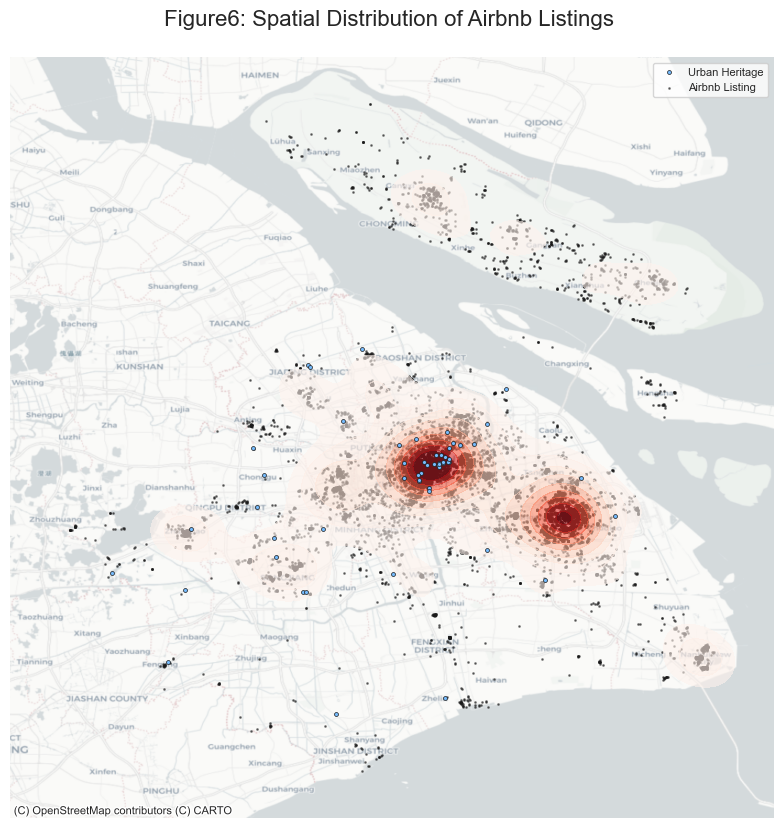

In [6]:
import contextily as ctx
from shapely.geometry import Polygon, MultiPolygon
# Create thresholds
levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# Create plot
f, ax = plt.subplots(ncols=1, figsize=(8, 10))
#Add urban heritages
p_g.plot(ax = ax, zorder =4, markersize=8,color='xkcd:sky blue',linewidths=.5,edgecolor='k',label='Urban Heritage')
# Kernel Density Estimation-airbnb listings
kde = sns.kdeplot(
    ax=ax,
    x=airbnb_g['geometry'].x,
    y= airbnb_g['geometry'].y,
    levels = levels,
    fill=True,
    cmap='Reds',
    alpha=0.6, 
    zorder=3
)
#Add airbnb listings
airbnb_g.plot(ax=ax, color = 'k', zorder=2, markersize = 1, alpha = .5,label='Airbnb Listing')
# Add a basemap
# ctx.add_basemap(ax=ax,crs = airbnb_g.crs.to_string())
ctx.add_basemap(ax=ax,crs = airbnb_g.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.legend(fontsize=8)
plt.tight_layout()
plt.title('Figure6: Spatial Distribution of Airbnb Listings \n',fontsize=16)
plt.savefig('Spatial Distribution of Airbnb Listings.png',dpi=300)

Figure 7 shows the spatial distribution of the listings that mention urban built heritages and the urban heritages, along with a kernel density map of these listings. The kernel density map shows that the main agglomeration of these listings is the inner city, an area that overlaps with the agglomeration of urban heritages. The second dense agglomeration is around Shanghai Disneyland. This area is within the encirclement of the four neighbouring urban built heritages. In addition, there is also agglomeration in Zhujiajiao town and Songjiang District. Chongming District, on the other hand, which has no urban heritage, has no agglomeration and only individual listings mention urban heritage.

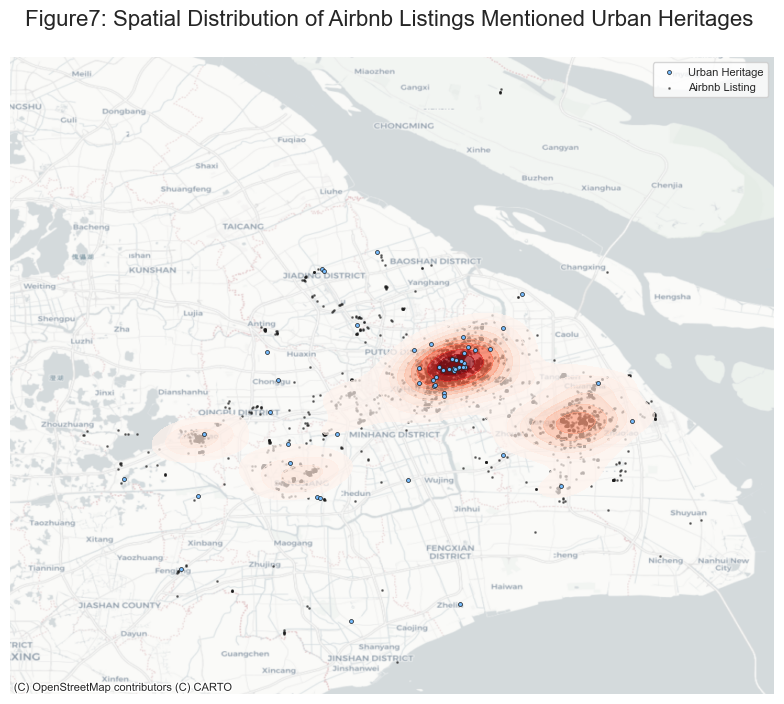

In [7]:
import contextily as ctx
from shapely.geometry import Polygon, MultiPolygon
# Create thresholds
levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
# Create plot
f, ax = plt.subplots(ncols=1, figsize=(8, 10))
#Add urban heritages
p_g.plot(ax = ax, zorder =4, markersize=8,color='xkcd:sky blue',linewidths=.5,edgecolor='k',label='Urban Heritage')
# Kernel Density Estimation-airbnb listings
kde = sns.kdeplot(
    ax=ax,
    x=result_g['geometry'].x,
    y= result_g['geometry'].y,
    levels = levels,
    fill=True,
    cmap='Reds',
    alpha=0.7, 
    zorder=3
)
#Add airbnb listings
result_g.plot(ax=ax, color = 'k', zorder=2, markersize = 1, alpha = .5,label='Airbnb Listing')
# Add a basemap
# ctx.add_basemap(ax=ax,crs = airbnb_g.crs.to_string())
ctx.add_basemap(ax=ax,crs = result_g.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.legend(fontsize=8)
plt.tight_layout()
plt.title('Figure7: Spatial Distribution of Airbnb Listings Mentioned Urban Heritages \n',fontsize=16)
plt.savefig('Spatial Distribution of Airbnb Listings Mentioned Urban Heritages.png',dpi=300)

While the above section presents the results of the overall analysis, the following section will provide an in-depth analysis from the perspective of each city heritage. The results show that of the 55 urban heritage studied, 13 were not mentioned. The percentage of airbnbs mentioning different urban heritage has five level, as shown in Table 2. From the results, the percentage of mentions of different urban heritages in the listings is low and varies greatly between individuals. The most frequently mentioned is 'The Bund', with 20.6% of listings mentioning it. 

In [8]:
print('\033[1mTable2: The Percentage of airbnb mentioning different urban heritage \033[0m') 
pd.set_option('max_colwidth',200)
a=['non mentioned','','','', 'less than 0.1%', '','','','','','','', 'less than 1%', '', '', '', 'less than 10%', '', '10% and over']
b=['Zhangyan Town, Maqiao Ancient Cultural Sites, Qinglong Town Ruins, Tang Toroni Sutra Stela, Shanghai Tilanqiao prison', 
    'Shanghai Xu Guangqi Tomb, Chenxiang Temple, Fuquanshan Ancient Cultural Sites, Huatingdong Stone Pond', 
    'Communist Youth League Central Authority Site Memorial Hall,Shanghai Yuan Dynasty Water Gate Museum',
    'University Of Shanghai For Science And Technology(Jungong Road), Hostel of the First National Congress of CPC', 
    
    '(Longhua Memorial Park of Revolutionary Martyrs ,0.01), (Shanghai Zhenru Temple ,0.01), (Songze Cultural Ruins ,0.01)', 
    '(ShangHai ZiLaiShui KeJiGuan, 0.01), (Gaoqiao Old Street, 0.02), (Shanghai Slaugterhouse under Municipal Committee, 0.02)',
    '(Sihang Warehouse Battle Memorial, 0.02), (East China University of Political Science and Law(Changning), 0.02), (Liantang Ancient Town, 0.03)',
    '(Luodian Ancient Town, 0.03), (Shanghai Postal Museum, 0.03), (Jiading Confucian Temple, 0.03), (Holy Trinity Church, 0.03)',
    '(Sijing Ancient Town, 0.04), (Songqingling Cemetery Park, 0.05), (Square Pagoda, 0.05), (Luxun Tomb, 0.06)',
    '(Jiading Zhouqiao Scenic Area, 0.06), (Jinze Ancient Town, 0.07), (The Memorial of the 1st National Congress of CPC, 0.08)',
    '(Sheshan Observatory, 0.08), (Xujiahui Catholic Church, 0.08), (The Memorial Site of the 2nd National Congress of CPC, 0.08)',
    '(Shanghai Jiao Tong University(XuHui), 0.08), (Shanghai Science Hall, 0.08), (Shanghai Zhang Wentian Former Residence, 0.09)',
    
    '(Chinese Welfare Association Children\'s Palace, 0.1), (Park Hotel Shanghai, 0.11), (Fengjing Water Town, 0.15)',
    '(Zhaojialou Ancient Town, 0.22), (Nanxiang Ancient Town, 0.28), (Hengshan Moller Villa Hotel, 0.32)',
    '(Shanghai Museum of Sun Yat-sen\'s Former Residence, 0.37), (Former Residence of Zhou Enlai in Shanghai, 0.37)', 
    '(Soong Ching-ling Memorial Residence, 0.47), (Shanghai Longhua Temple, 0.5)',
    
    '(Zhujiajiao Antient Water Town, 1.67), (Chuansha Ancient Town, 1.67), (Guangfulin Ancient Relics Park, 1.93)',
    '(Xinchang Ancient Town, 3.23), (Yu Garden, 7.6)',
    
    '(The Bund, 20.6)']
df={"Level" : a,
   "Built Heritage_Percent" : b}
table2= pd.DataFrame(df)
left_aligned_table2 = table2.style.set_properties(**{'text-align': 'left'})
left_aligned_table2 = left_aligned_table2.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])
display(left_aligned_table2)

Table2: The Percentage of airbnb mentioning different urban heritage 


,Level,Built Heritage_Percent
0,non mentioned,"Zhangyan Town, Maqiao Ancient Cultural Sites, Qinglong Town Ruins, Tang Toroni Sutra Stela, Shanghai Tilanqiao prison"
1,,"Shanghai Xu Guangqi Tomb, Chenxiang Temple, Fuquanshan Ancient Cultural Sites, Huatingdong Stone Pond"
2,,"Communist Youth League Central Authority Site Memorial Hall,Shanghai Yuan Dynasty Water Gate Museum"
3,,"University Of Shanghai For Science And Technology(Jungong Road), Hostel of the First National Congress of CPC"
4,less than 0.1%,"(Longhua Memorial Park of Revolutionary Martyrs ,0.01), (Shanghai Zhenru Temple ,0.01), (Songze Cultural Ruins ,0.01)"
5,,"(ShangHai ZiLaiShui KeJiGuan, 0.01), (Gaoqiao Old Street, 0.02), (Shanghai Slaugterhouse under Municipal Committee, 0.02)"
6,,"(Sihang Warehouse Battle Memorial, 0.02), (East China University of Political Science and Law(Changning), 0.02), (Liantang Ancient Town, 0.03)"
7,,"(Luodian Ancient Town, 0.03), (Shanghai Postal Museum, 0.03), (Jiading Confucian Temple, 0.03), (Holy Trinity Church, 0.03)"
8,,"(Sijing Ancient Town, 0.04), (Songqingling Cemetery Park, 0.05), (Square Pagoda, 0.05), (Luxun Tomb, 0.06)"
9,,"(Jiading Zhouqiao Scenic Area, 0.06), (Jinze Ancient Town, 0.07), (The Memorial of the 1st National Congress of CPC, 0.08)"


To find the possible reason for the difference among individuals, I want to find out the relationship between urban heritages popularity and the percentage of mentions. To do this, the Pearson Correlation Coefficient was calculated using the popularity rating (out of 10) of each urban heritages provided by Ctrip (a well-known Chinese online travel service platform) and the percentage of mentions. The result of Pearson Correlation Coefficient is 0.56, indicating a moderate positive correlation between the popularity and the percentage of mentions. Figure 8 shows the relationship between urban heritage popularity and the percentage of mentions.

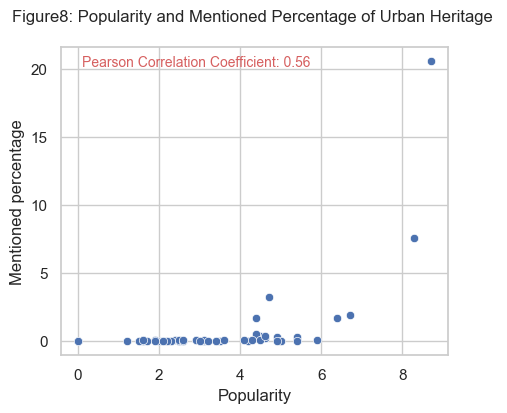

In [9]:
x_simple = np.array(p['heat'])
y_simple = (np.array(round(p['m_amount']/len(airbnb)*100,2)))
pccs = np.corrcoef(x_simple, y_simple)
pc_s = 'Pearson Correlation Coefficient: '+str(round(pccs[0][1],2))

f, ax = plt.subplots(ncols=1, figsize=(5, 4))
sns.scatterplot(
    x=x_simple, y=y_simple
)
ax.set_xlabel("Popularity")
ax.set_ylabel("Mentioned percentage")
ax.text(0.1,20.2,pc_s,horizontalalignment = 'left', color='r',fontsize=10)
#ylabel: Mentioned times
plt.title('Figure8: Popularity and Mentioned Percentage of Urban Heritage \n')
plt.savefig('Popularity and Mentioned Percentage of Urban Heritage.png',dpi=300)

The follow analysis is based on the mentioned percentage of each urban heritage in the listings with same district as the urban heritage. The results show that 14 urban heritages were not mentioned. Of the urban heritage mentioned, the percentage of mentions was divided into three levels: less than 1%, less than 10%, and 10% and more. Figure 9 shows the variation in the percentage of mentions of urban heritage in the overall, same-district and 2km radius circular buffer listings. These urban heritages were mentioned in more than 1% listings in the whole city. As can be seen, the value for same district or 2km radius circular buffer listings are higher than the percentage of mentions for all listings, indicating that the frequency of mentions is also influenced by spatial factors. It also shows that the percentage of urban heritage mentioned by listings in the same district or 2km radius circular buffer still varies between individuals. For the percentage of mentions in the same district, the Pearson Correlation Coefficient for popularity and percentage is 0.67, indicating a stronger positive correlation between popularity and mentioned percentage. Figure 10 shows the relationship between urban heritage popularity and percentage of mentions.

C:\Users\Angle Lu\AppData\Local\Temp\ipykernel_6820\1043449957.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='m_percent', axis=0, ascending=False, inplace=True, na_position='last')


<Figure size 1500x1200 with 0 Axes>

C:\Users\Angle Lu\anaconda3\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65279 (\N{ZERO WIDTH NO-BREAK SPACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


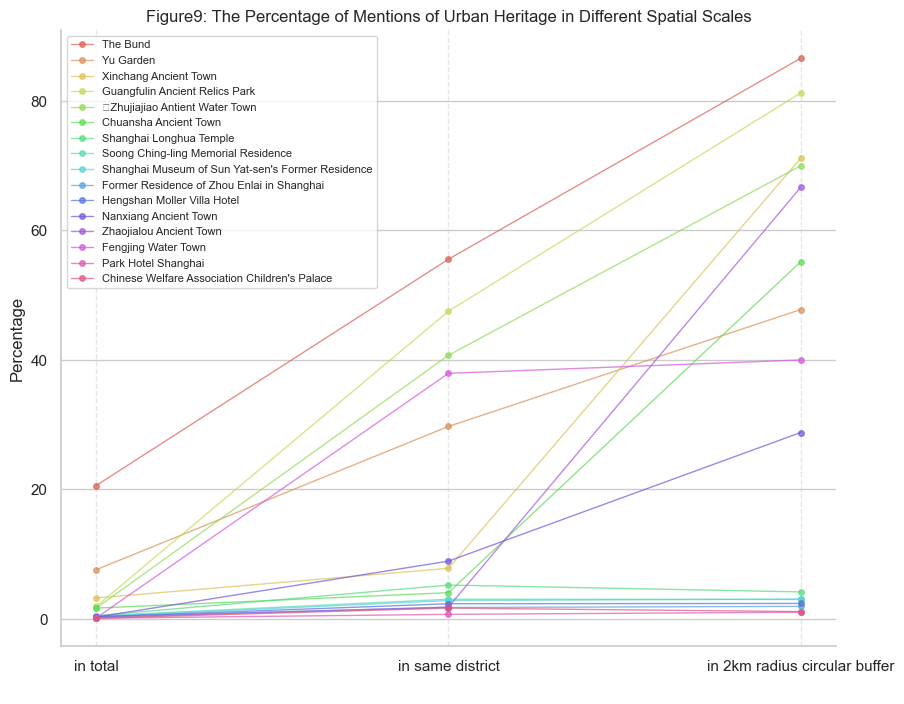

In [10]:
#Figure 9
p['m_percent'] = [round(i/len(airbnb)*100,2) for i in p['m_amount']]
df = p[p['m_percent']>=0.1]
df.sort_values(by='m_percent', axis=0, ascending=False, inplace=True, na_position='last')
df = df.reset_index(drop=True)
sns.color_palette("Set2")
x = ['in total','in same district','in 2km radius circular buffer']
colors = sns.color_palette("hls",16)

plt.figure(1, figsize=(15,12))
fig, ax = plt.subplots(figsize=(10,8))
for i in range(len(df)):
    y = [df.loc[i,'m_percent'],df.loc[i,'sd_m_percent_in_d'],df.loc[i,'2km_m_percent']]
    label_s = df.loc[i,'listing_en']
    plt.plot(x, y, color=colors[i],marker='o', markersize = 4, linewidth=1,alpha = 0.7, label=label_s)
plt.grid(linestyle='--', axis = 'x',alpha = .5)
plt.title('Figure9: The Percentage of Mentions of Urban Heritage in Different Spatial Scales') 
plt.legend(fontsize=8)
plt.xlabel(' ')
plt.ylabel('Percentage')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

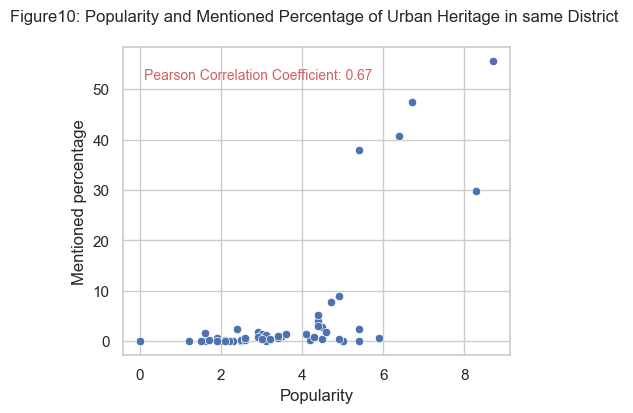

In [11]:
# Figure10
x_simple = np.array(p['heat'])
y_simple = np.array(p['sd_m_percent_in_d'])
pccs = np.corrcoef(x_simple, y_simple)
pc_s = 'Pearson Correlation Coefficient: '+str(round(pccs[0][1],2))

f, ax = plt.subplots(ncols=1, figsize=(5, 4))
sns.scatterplot(
    data=p, x="heat", y="sd_m_percent_in_d"
)
ax.set_xlabel("Popularity")
ax.set_ylabel("Mentioned percentage")
ax.text(0.1,52,pc_s,horizontalalignment = 'left', color='r',fontsize=10)
plt.title('Figure10: Popularity and Mentioned Percentage of Urban Heritage in same District \n')
plt.savefig('Popularity and Mentioned Percentage of Urban Heritage in same District.png',dpi=300)

## Discussion

From the result, it shows that Shanghai's Airbnb listing is widely distributed, with Airbnb listings available in all districts. Its urban heritage resources are not scarce, with only Chongming District having no national urban built heritage. However, the percentage of listing descriptions that mention urban heritage is not high, at 30.48%. Though the urban heritages are known as a positive factor on the sharing economy and the government want to preserve them to build up the city branding, they are not the most important for Shanghai Airbnb hosts. In terms of spatial distribution, the concentration of listings that mention urban heritage are influenced by the concentration of listings and the distribution of urban heritage. That is, although the area is a concentration of listings, it is not common for local listings to mention urban heritages because there is no urban heritages around, such as in Chongming District. On the other hand, although the area is not a concentration of urban heritages, references to urban heritage are more common in the area because it is a major concentration of listings and there is urban heritage scattered around it, such as area near Shanghai Disneyland.

The observations of each urban heritage show that, with the exception of Chenxiang Temple, the unmentioned urban heritage has a low level of popularity. One possible reason why Chenxiang Temple not have been mentioned is its proximity to Yu Garden (the second most frequently mentioned urban heritage) and Yu Garden is more popular than it. The percentage of being mentioned varies considerably between urban built heritages. The Pearson Correlation Coefficient between the percentage of mentions and the popularity of different urban heritages shows that the hotter the urban heritage, the higher the probability of being mentioned. The change in the percentage of mentions of urban heritage in general, in the same district and in the 2km radius circular buffer zone shows that urban heritages near the listing is more likely to be added to the listing description by the host as a selling point.

Overall, the urban built heritages mined from the Airbnb listing description shows that the value of urban heritage in the eyes of the host is influenced by its proximity to their listing, the number of nearby listings, and the popularity of the urban heritage itself. The closer the urban heritage is to the listing and the more popular the heritage is, the more likely it is to be mentioned in the listing description, highlighting its positive effect on the sharing economy. When there is a concentration of housing within an area and urban heritage is distributed, the area may also a concentration of listings mentioned urban heritages. Among the individual urban heritage analysis, 'The Bund' is so famous that the listings mentioned it in the description are located in all but one of the districts. Because the inner city and the area near Shanghai Disneyland are the two main agglomerations of Airbnb listings, and the inner city is closer to The Bund, the inner city and the area near Shanghai Disneyland become the first and second largest agglomerations of listings mentioned 'The Bund', as shown in the kernel density map in Figure 11.

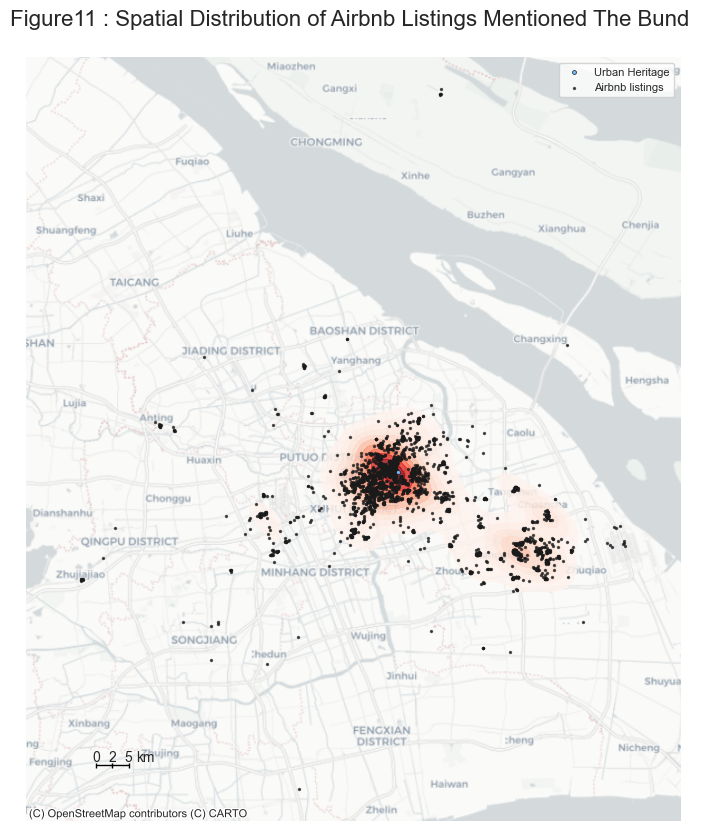

In [12]:
result['id'] = [str(int(i)) for i in result['id']]
def p_l(n):
    l = p.loc[n,'m_id'][1:-1].split(', ')
    listp = []
    for ll in l:
        a = result[result['id']==ll]
        a = a.reset_index(drop=True)
        listp.append(a)
    
    p_l_sub = pd.concat(listp).reset_index(drop=True)
    return p_l_sub

def add_scalebar(ax,lon0,lat0,length,size=0.45):
    ax.hlines(y=lat0,  xmin = lon0, xmax = lon0+length/111, colors="black", ls="-", lw=1)
    ax.vlines(x = lon0, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=1)
    ax.vlines(x = lon0+length/2/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=1)
    ax.vlines(x = lon0+length/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=1)
    ax.text(lon0+length/111,lat0+size+0.001,'%d' % (length),horizontalalignment = 'center', fontsize=10)
    ax.text(lon0+length/2/111,lat0+size+0.001,'%d' % (length/2),horizontalalignment = 'center', fontsize=10)
    ax.text(lon0,lat0+size+0.001,'0',horizontalalignment = 'center', fontsize=10)
    ax.text(lon0+length/111/2*3,lat0+size+0.001,'km',horizontalalignment = 'center', fontsize=10)

def k_d_e(p_g, sub_g):
    # Create thresholds
    levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    # Create plot
    f, ax = plt.subplots(ncols=1, figsize=(10, 8))
    #Add urban heritages
    p_g.plot(ax = ax, zorder =4, markersize=8,color='xkcd:sky blue',linewidths=.5,edgecolor='k',label='Urban Heritage')

    # Kernel Density Estimation
    kde = sns.kdeplot(
        ax=ax,
        x=sub_g['geometry'].x,
        y= sub_g['geometry'].y,
        levels = levels,
        fill=True,
        cmap='Reds',
        alpha=0.8
    )
    # Add a basemap
    ctx.add_basemap(ax=ax,crs = airbnb_g.crs.to_string(), source=ctx.providers.CartoDB.Positron)
    sub_g.plot(ax = ax, zorder = 3, markersize=2, color='k', alpha = .7, label='Airbnb listings')
    ax.set_axis_off()
    ##
    s_x = sub_g.longitude.min()+round((sub_g.longitude.max()-sub_g.longitude.min())/35,5)
    s_y = sub_g.latitude.min()+round((sub_g.latitude.max()-sub_g.latitude.min())/30,5)
    add_scalebar(ax,s_x,s_y,5,size=0.003) 
    plt.tight_layout()
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.title('Figure11 : Spatial Distribution of Airbnb Listings Mentioned The Bund \n',fontsize=16)
    plt.show()  


S = p[p.listing_en == 'The Bund'].index.tolist()[0]
p_s_g = p_g[p_g.listing_en == 'The Bund']
sub = p_l(S)
sub_g = gpd.GeoDataFrame(sub,geometry = gpd.points_from_xy(sub.longitude,sub.latitude),crs = 'EPSG:4326')
sub_g = sub_g.to_crs(4490)
k_d_e(p_s_g,sub_g)

## Conclusion

In this study, March 2022 Shanghai Airbnb listings and Shanghai national urban built heritages were used as the research objects to extract the urban heritages mentioned in the listing description by word segmentation and keyword filtering. The results of text mining are used to analyse the characteristics of the mentioned urban heritage by statistical description, mapping, kernel density maps and calculating Pearson Correlation Coefficient. This study found that the percentage of listings mentioning urban heritage is low, with only 30.48% of listings mentioning urban heritage. The frequency of mentions of urban heritage is related to its popularity and relative location to the listings. The listings are more likely to mention the urban heritages with higher popularity, located in the same district or close to it. The clustering of listings that mention urban heritage is influenced by the clustering of listings and the distribution of urban heritage. Only when the area is a listings agglomeration and there are urban heritages distributed nearby, does the area show a agglomeration of listing that mentions urban heritage. And when the urban heritage is popular enough, the influence of the location to the likelihood of being mentioned is weakened. 

In this case, urban heritage is not an element that would necessarily appear in the description of the listing. Hosts prefer to include it in their listing descriptions when the urban heritage has a high level of popularity and is close to their listing. Urban heritage that is much less popular is rarely mentioned. In this case, there are 13 urban heritages not being mentioned. Even though all the urban heritages mentioned in this study are national level and almost all of them are open to the public, from the public’s point of view, their impact on the sharing economy is different and some of them are too weak to be considered. It is therefore recommended that the government, in preserving these urban heritages and being willing to brand the city with these built heritages, promote them more to the citizens, especially to those who are close to or in the same district as the urban heritage, and involve at least some of them in this process.

There are some areas where this study could be improved. Firstly, the locations of the urban heritages collected in this study are not precise, and even three of the coordinates are out of the range of the district in which they are located. The imprecise locations will affect the analysis of the relationship between location and the frequency of mentions of urban heritage. Secondly, for the identification of urban heritage in texts, the method used in this study is less efficient, although it can improve the accuracy of text mining by collecting keywords from samples. When more urban heritage is studied, it takes longer time. Finally, for the results of text mining, although this study analyse the from the numerical and spatial view, the method used is basic and could be explored in more depth analysis.

## Reference

Fierro, A. and Aranburu, I. 2019, "Airbnb Branding: Heritage as a Branding Element in the Sharing Economy", *Sustainability (Basel, 
 Switzerland)*, vol. 11, no. 1, pp. 74.

Liu, T., Butler, R.J. & Zhang, C. 2019, "Evaluation of public perceptions of authenticity of urban heritage under the conservation paradigm 
 of Historic Urban Landscape-a case study of the Five Avenues Historic District in Tianjin, China", *Journal of architectural conservation*, 
 vol. 25, no. 3, pp. 228-251.

Luo, R., Xu, J., Zhang, Y., Zhang, Z., Ren, X., & Sun, X. (2019). Pkuseg: A toolkit for multi-domain chinese word segmentation. *arXiv 
 preprint arXiv:1906.11455.

Madgin, R. (2020) 'A place for urban conservation? The changing values of Glasgow’s built heritage', in Kintrea, K. and Madgin, R. (ed(s).)
 *Transforming Glasgow Beyond the Post-industrial City.* Bristol, UK: Policy Press, 221-238.

Peh, C. (2014) *Politicizing Heritage: The Intangibility of Shanghai’s Shikumens.* Bachelor of Arts undergraduate dissertation in History, 
 National University of Singapore.
 
Welle, D. (2022) Airbnb cuts all listings in China, dw.com. *Deutsche Welle.* Available at: https://www.dw.com/en/airbnb-cuts-all-listings-
 in-china-amid-fierce-competition/a-61910714.

## Appendix

Appendix 1:Collect the location information

Appendix 2: Data cleaning

Appendix 3: Collect keywords

Appendix 4: Text mining

Appendix 5: Calculating indicators